# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import time
from PIL import Image

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, roc_auc_score, make_scorer)

import matplotlib.pyplot as plt
import seaborn as sns

# Util funcs

Podaci su prečišćeni korišćenjem funkcije `handle_invalid_action_images(dataset)` dostupnoj i korišćenoj u svesci `../02_dataset_creation/07_handle_invalid_action_images.ipynb`, tako da u nastavku nisu neophodne dodatne provere u vezi formata slika, i sl.

In [2]:
def load_data(path, y):
    X = []
    path = os.path.join(path, y)
    for image_file in os.listdir(path):
        image_path = os.path.join(path, image_file)
        if os.path.isfile(image_path):
            with Image.open(image_path) as img:
                img = img.convert('RGB')
                X.append(np.array(img))
    
    return X, [y] * len(X)

In [3]:
def print_time_taken(start_time, end_time):
    elapsed_time = end_time - start_time
    hours, rem = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f"Time taken: {int(hours):02}:{int(minutes):02}:{seconds:05.2f}")

# Korišćenje skupa dobijenog automatskom obradom, pre ručne provere i relabeliranja

## Učitavanje i preprocesiranje podataka

In [4]:
images = []
labels = []
for i, label in enumerate(os.listdir('/app/tennis_data/stroke_recognition_dataset/master/v1.0/action_images_dataset_original_v1.0/bottom')):
    X, y = load_data('/app/tennis_data/stroke_recognition_dataset/master/v1.0/action_images_dataset_original_v1.0/bottom', label)
    images += X
    labels += y
images = np.array(images)

In [5]:
X = images.reshape((len(images), -1))
y = labels

In [6]:
class_labels = ['backhand', 'forehand', 'other', 'serve']

In [7]:
bh_cnt = sum([1 for l in y if l == 'backhand'])
fh_cnt = sum([1 for l in y if l == 'forehand'])
other_cnt = sum([1 for l in y if l == 'other'])
serve_cnt = sum([1 for l in y if l == 'serve'])
print(f'Backhands count: {bh_cnt}, Forehands count: {fh_cnt}, Other count: {other_cnt}, Serve count: {serve_cnt}')
print(f'All strokes count: {len(y)}')

Backhands count: 2038, Forehands count: 2412, Other count: 6217, Serve count: 1634
All strokes count: 12301


## Isprobavanje metode potpornih vektora

**Napomena da je u celom projektu korišćeno determinističko razdvajanje na trening, validacioni i test skup (random_state=42), tako da je analiza test skupa pokrenuta tek na kraju celog projekta u svakoj svesci za svaki model.**

In [8]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, 
                                                                          test_size=0.1, 
                                                                          stratify=y, 
                                                                          random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_validation, y_train_validation, 
                                                  test_size=0.2, 
                                                  stratify=y_train_validation, 
                                                  random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

clf = SVC(kernel='rbf', gamma='scale', shrinking=True, random_state=7)
clf.fit(X_train, y_train)

SVC(random_state=7)

In [9]:
y_val_preds = clf.predict(X_val)
y_train_preds = clf.predict(X_train)

In [10]:
print("\nTraining set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))


Training set scores:
Accuracy: 0.841576332429991
Precision: 0.8349035257459947
Recall: 0.8181661857386451
F1 Score: 0.825545830384464

Validation set scores:
Accuracy: 0.8107497741644083
Precision: 0.7952100740147309
Recall: 0.778661719635221
F1 Score: 0.7847659448574731


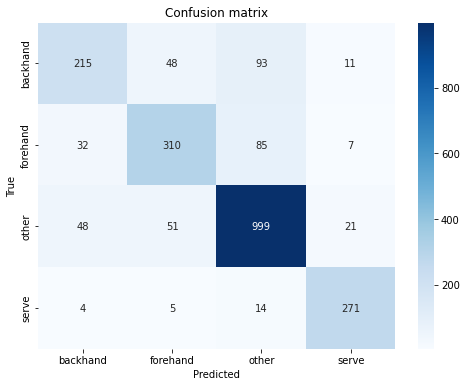

In [11]:
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [12]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

    backhand       0.78      0.70      0.74      1467
    forehand       0.80      0.74      0.77      1737
       other       0.86      0.91      0.88      4476
       serve       0.91      0.93      0.92      1176

    accuracy                           0.84      8856
   macro avg       0.83      0.82      0.83      8856
weighted avg       0.84      0.84      0.84      8856



In [13]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

    backhand       0.72      0.59      0.65       367
    forehand       0.75      0.71      0.73       434
       other       0.84      0.89      0.86      1119
       serve       0.87      0.92      0.90       294

    accuracy                           0.81      2214
   macro avg       0.80      0.78      0.78      2214
weighted avg       0.81      0.81      0.81      2214



## Pronalaženje najboljih hiperparametara

In [14]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y,
                                                                          test_size=0.2, 
                                                                          stratify=y, 
                                                                          random_state=42)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train_validation, y_train_validation, 
                                                  test_size=0.2, 
                                                  stratify=y_train_validation, 
                                                  random_state=42)

In [16]:
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

params = {
    'svc__C': [10**i for i in range(-2, 2)],
    'svc__kernel': ['sigmoid', 'rbf'],
    'svc__gamma': [10**i for i in range(-2, 2)],
}

grid_model = Pipeline(steps=[('scaler', StandardScaler()),
                             ('svc', SVC(random_state=42))])

### Analiza hiperparametara

In [17]:
start = time.time()

grid_params_svc = GridSearchCV(grid_model, param_grid=params, scoring='f1_macro', verbose=True,
                               cv=kf, return_train_score=True, n_jobs=60)
grid_params_svc.fit(X_train_validation, y_train_validation)

end = time.time()
print_time_taken(start, end)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Time taken: 00:09:00.49


In [18]:
best_model = grid_params_svc.best_estimator_

print(f"Best score (GridSearchCV): {grid_params_svc.best_score_}")
print(f"Best parameters: {grid_params_svc.best_params_}\n")

y_train_preds = best_model.predict(X_train)
print("Training set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

y_val_preds = best_model.predict(X_val)
print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))

Best score (GridSearchCV): 0.7325205781131996
Best parameters: {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}

Training set scores:
Accuracy: 0.9336890243902439
Precision: 0.9383699046322573
Recall: 0.9251388208031404
F1 Score: 0.931195952236737

Validation set scores:
Accuracy: 0.9232723577235772
Precision: 0.9286128647978567
Recall: 0.9130897947469048
F1 Score: 0.9198001957145822


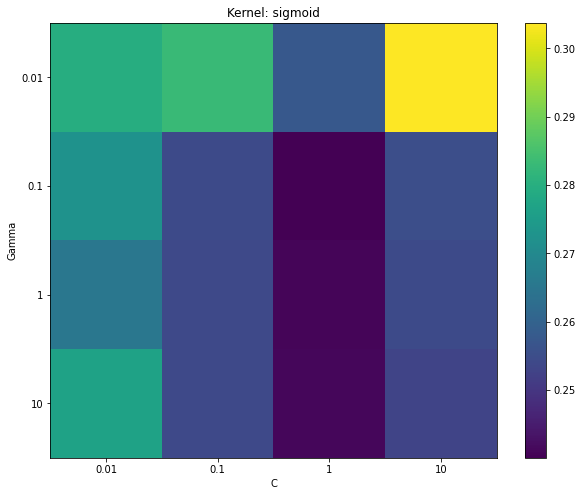

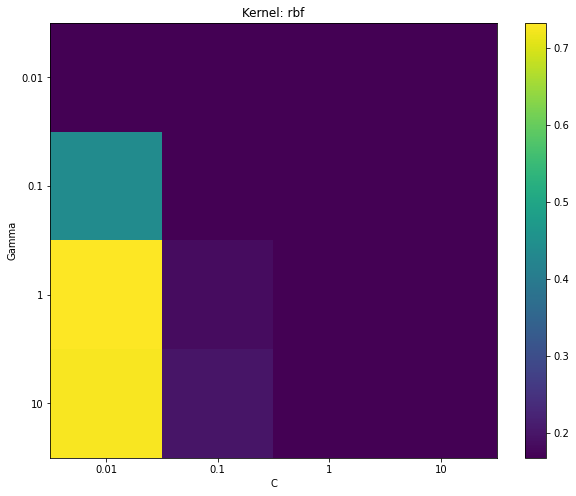

In [19]:
Cs = params['svc__C']
gammas = params['svc__gamma']
kernels = params['svc__kernel']

cv_results = pd.DataFrame(grid_params_svc.cv_results_)

for kernel in kernels:
    mask = cv_results['param_svc__kernel'] == kernel
    cv_test_score = cv_results[mask]['mean_test_score'].values.reshape(len(gammas), len(Cs))
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv_test_score, cmap='viridis', aspect='auto')
    plt.colorbar()
    
    plt.ylabel('Gamma')
    plt.yticks(np.arange(len(gammas)), gammas)
    
    plt.xlabel('C')
    plt.xticks(np.arange(len(Cs)), Cs)
    
    plt.title(f'Kernel: {kernel}')
    plt.show()

Sa plotova vidimo da su optimalne vrednosti hiperparametra `gamma` za različite kernele u različitom smeru. Jednom odgovaraju veće, jednom manje. Tako da ćemo u nastavku pokrenuti pretragu parametara za svaki kernel posebno.

### Za sigmoid kernel

In [21]:
start = time.time()

params_sig = {
    'svc__C': [10**i for i in range(0, 6)],
    'svc__kernel': ['sigmoid'],
    'svc__gamma': [10**i for i in range(-7, 1)],
}

grid_params_svc_sig = GridSearchCV(grid_model, param_grid=params_sig, scoring='f1_macro', verbose=True,
                                   cv=kf, return_train_score=True, n_jobs=60)
grid_params_svc_sig.fit(X_train_validation, y_train_validation)

end = time.time()
print_time_taken(start, end)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Time taken: 00:07:44.43


In [22]:
best_model = grid_params_svc_sig.best_estimator_

print(f"Best score (GridSearchCV): {grid_params_svc_sig.best_score_}")
print(f"Best parameters: {grid_params_svc_sig.best_params_}\n")

y_train_preds = best_model.predict(X_train)
print("Training set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

y_val_preds = best_model.predict(X_val)
print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))

Best score (GridSearchCV): 0.7608882945292509
Best parameters: {'svc__C': 100000, 'svc__gamma': 1e-06, 'svc__kernel': 'sigmoid'}

Training set scores:
Accuracy: 0.834349593495935
Precision: 0.8272817455105912
Recall: 0.8139477864495107
F1 Score: 0.8199341024997844

Validation set scores:
Accuracy: 0.8038617886178862
Precision: 0.7869042756804914
Recall: 0.7817262927381905
F1 Score: 0.7834829312395551


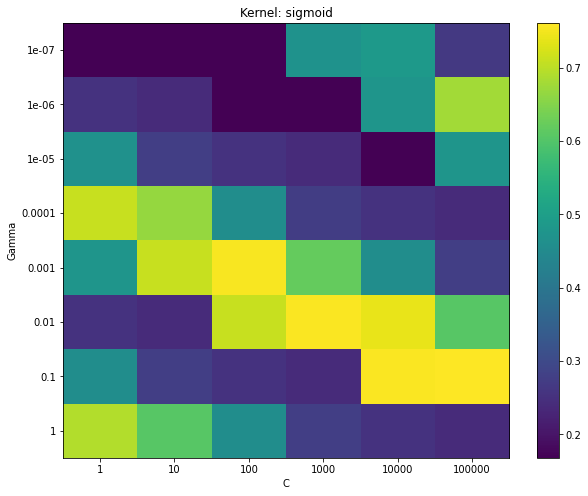

In [23]:
Cs = params_sig['svc__C']
gammas = params_sig['svc__gamma']
kernels = params_sig['svc__kernel']

cv_results = pd.DataFrame(grid_params_svc_sig.cv_results_)

for kernel in kernels:
    mask = cv_results['param_svc__kernel'] == kernel
    cv_test_score = cv_results[mask]['mean_test_score'].values.reshape(len(gammas), len(Cs))
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv_test_score, cmap='viridis', aspect='auto')
    plt.colorbar()
    
    plt.ylabel('Gamma')
    plt.yticks(np.arange(len(gammas)), gammas)
    
    plt.xlabel('C')
    plt.xticks(np.arange(len(Cs)), Cs)
    
    plt.title(f'Kernel: {kernel}')
    plt.show()

### Za rbf kernel

In [24]:
start = time.time()

params_rbf = {
    'svc__C': [10**i for i in range(-1, 3)],
    'svc__kernel': ['rbf'],
    'svc__gamma': [10**i for i in range(-5, 1)],
}

grid_params_svc_rbf = GridSearchCV(grid_model, param_grid=params_rbf, scoring='f1_macro', verbose=True,
                                   cv=kf, return_train_score=True, n_jobs=60)
grid_params_svc_rbf.fit(X_train_validation, y_train_validation)

end = time.time()
print_time_taken(start, end)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Time taken: 00:07:09.48


In [25]:
best_model = grid_params_svc_rbf.best_estimator_

print(f"Best score (GridSearchCV): {grid_params_svc_rbf.best_score_}")
print(f"Best parameters: {grid_params_svc_rbf.best_params_}\n")

y_train_preds = best_model.predict(X_train)
print("Training set scores:")
print("Accuracy:", accuracy_score(y_train, y_train_preds))
print("Precision:", precision_score(y_train, y_train_preds, average='macro'))
print("Recall:", recall_score(y_train, y_train_preds, average='macro'))
print("F1 Score:", f1_score(y_train, y_train_preds, average='macro'))

y_val_preds = best_model.predict(X_val)
print("\nValidation set scores:")
print("Accuracy:", accuracy_score(y_val, y_val_preds))
print("Precision:", precision_score(y_val, y_val_preds, average='macro'))
print("Recall:", recall_score(y_val, y_val_preds, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_preds, average='macro'))

Best score (GridSearchCV): 0.8077437851299445
Best parameters: {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

Training set scores:
Accuracy: 0.898119918699187
Precision: 0.8985318153635016
Recall: 0.8899852084374231
F1 Score: 0.8937490134550388

Validation set scores:
Accuracy: 0.8861788617886179
Precision: 0.883567224255009
Recall: 0.8768321779156925
F1 Score: 0.8793546644546069


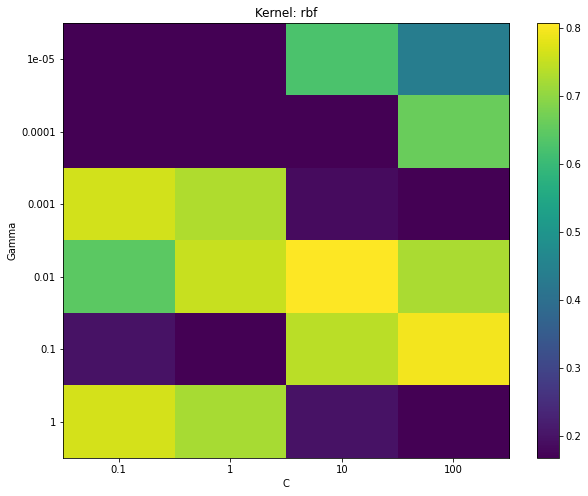

In [26]:
Cs = params_rbf['svc__C']
gammas = params_rbf['svc__gamma']
kernels = params_rbf['svc__kernel']

cv_results = pd.DataFrame(grid_params_svc_rbf.cv_results_)

for kernel in kernels:
    mask = cv_results['param_svc__kernel'] == kernel
    cv_test_score = cv_results[mask]['mean_test_score'].values.reshape(len(gammas), len(Cs))
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cv_test_score, cmap='viridis', aspect='auto')
    plt.colorbar()
    
    plt.ylabel('Gamma')
    plt.yticks(np.arange(len(gammas)), gammas)
    
    plt.xlabel('C')
    plt.xticks(np.arange(len(Cs)), Cs)
    
    plt.title(f'Kernel: {kernel}')
    plt.show()

Nakon analize oba kernela, biramo rbf i njegov najbolji model, tako da ove rezultate proglašavamo konačnim kvalitetom modela. Napomena kao i u ostalim slučajevima, neće biti treniran model nad svim podacima iz skupa (uključujući i test), nego će biti eksportovana verzija trenirana nad trening i validacionim skupom da bi se prilikom demonstracije ili bilo kog daljeg koraka mogli koristiti primeri iz test skupa i dobijala relevantna predviđanja.

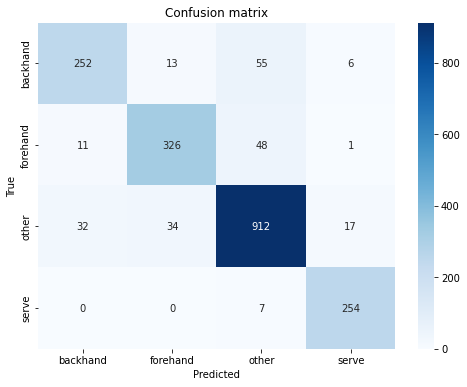

In [27]:
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
print(classification_report(y_train, y_train_preds))

              precision    recall  f1-score   support

    backhand       0.87      0.80      0.84      1304
    forehand       0.88      0.86      0.87      1544
       other       0.90      0.93      0.91      3978
       serve       0.94      0.97      0.96      1046

    accuracy                           0.90      7872
   macro avg       0.90      0.89      0.89      7872
weighted avg       0.90      0.90      0.90      7872



In [29]:
print(classification_report(y_val, y_val_preds))

              precision    recall  f1-score   support

    backhand       0.85      0.77      0.81       326
    forehand       0.87      0.84      0.86       386
       other       0.89      0.92      0.90       995
       serve       0.91      0.97      0.94       261

    accuracy                           0.89      1968
   macro avg       0.88      0.88      0.88      1968
weighted avg       0.89      0.89      0.89      1968



Možemo videti da se model ponaša prilično prihvatljivo što se generalizacije tiče. Naročito uzimajući u obzir to što ovaj skup sadrži dosta loše labeliranih primera.

## Procena modela na test skupu

In [30]:
y_test_preds = best_model.predict(X_test)

print("\nTest set scores:")
print("Accuracy:", accuracy_score(y_test, y_test_preds))
print("Precision:", precision_score(y_test, y_test_preds, average='macro'))
print("Recall:", recall_score(y_test, y_test_preds, average='macro'))
print("F1 Score:", f1_score(y_test, y_test_preds, average='macro'))


Test set scores:
Accuracy: 0.8289313287281593
Precision: 0.8246967481064159
Recall: 0.80645814205738
F1 Score: 0.8148414013192202


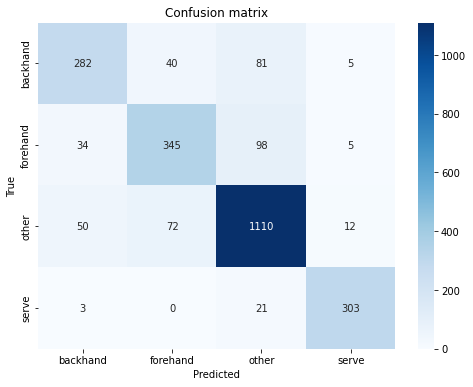

In [31]:
cm = confusion_matrix(y_test, y_test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [32]:
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

    backhand       0.76      0.69      0.73       408
    forehand       0.75      0.72      0.73       482
       other       0.85      0.89      0.87      1244
       serve       0.93      0.93      0.93       327

    accuracy                           0.83      2461
   macro avg       0.82      0.81      0.81      2461
weighted avg       0.83      0.83      0.83      2461



Konačno, kao i u svim implementiranim slučajevima dobijamo nešto lošije rezultate za test skup, a opet kao u svakom slučaju, ovi rezultati su i više nego prihvatljivi uzimajući sve u obzir.

# Čuvanje modela, odnosno celog pipeline-a za kasniju upotrebu

In [33]:
import pickle

if not os.path.exists('../../models'):
    os.makedirs('../../models')
        
with open('../../models/02_svm_original_data.pkl', 'wb') as f:
    pickle.dump(best_model, f)